<a href="https://colab.research.google.com/github/rushikeshnaik779/new_water/blob/main/window_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz



import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"


!pip install -q findspark
import findspark
findspark.init()


from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


# data because I am reading data analysis with python and pyspark
!git clone https://github.com/jonesberg/DataAnalysisWithPythonAndPySpark-Data.git

Cloning into 'DataAnalysisWithPythonAndPySpark-Data'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Receiving objects: 100% (71/71), 828.81 MiB | 26.59 MiB/s, done.
Updating files: 100% (59/59), done.


In [2]:
!ls DataAnalysisWithPythonAndPySpark-Data/window


gsod_light.parquet  gsod.parquet


In [3]:
gsod = spark.read.parquet('./DataAnalysisWithPythonAndPySpark-Data/window/gsod.parquet')

In [4]:
gsod.count()

12460217

In [5]:
gsod.show(1, False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+-----+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp  |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+----+----------+------+----------+------+---------+-----+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|917350|99999|2018|04 |21 |82.6|9         |9999.9|0         |1006.9|9        |993.2|9        |999.9|0          |3.7 |9         |8.5  |999.9|85.5|*       |74.5|        |0.31|G        |999.9|0  |0           |0               |0  

In [6]:
# calculating the lowest temperature for each year using groupBy()
import pyspark.sql.functions as F


coldest_temp = gsod.groupby("year").agg(F.min("temp").alias("temp"))
coldest_temp.orderBy("temp").show()

+----+------+
|year|  temp|
+----+------+
|2019|-114.7|
|2017|-114.7|
|2018|-113.5|
+----+------+



In [7]:
coldest_when = gsod.join(
    coldest_temp, how="left_semi", on=["year", "temp"]
).select("stn", "year", "mo", "da", "temp")


coldest_when.orderBy("year", "mo", "da").show()

+------+----+---+---+------+
|   stn|year| mo| da|  temp|
+------+----+---+---+------+
|896250|2017| 06| 20|-114.7|
|896060|2018| 08| 27|-113.5|
|895770|2019| 06| 15|-114.7|
+------+----+---+---+------+



In [8]:
# creating and using a simple window function to get the coldest day

# split apply combine --- data analysis world
# window function ---- Sql world

from pyspark.sql.window import Window

each_year = Window.partitionBy("year")

print(each_year)

In [9]:
# again reprinting the join code
coldest_when = gsod.join(
    coldest_temp, how="left_semi", on=["year", "temp"]
).select("stn", "year", "mo", "da", "temp")

coldest_when.orderBy("year", "mo", "da").show()

+------+----+---+---+------+
|   stn|year| mo| da|  temp|
+------+----+---+---+------+
|896250|2017| 06| 20|-114.7|
|896060|2018| 08| 27|-113.5|
|895770|2019| 06| 15|-114.7|
+------+----+---+---+------+



In [10]:
# Selecting the minimum temperature for each year using a window function

checking = (gsod
 .withColumn("min_temp", F.min("temp").over(each_year))
# .where("temp = min_temp")
 .select("year", "mo", "da", "stn", "temp", "min_temp")
 .orderBy("year", "mo", "da")
# .show()
 )

In [11]:
print(checking.count())
print(gsod.count())

12460217
12460217


In [12]:
# select
gsod.select(
    "year",
    "mo",
    "da",
    "stn",
    "temp",
    F.min("temp").over(each_year).alias("min_temp"),
).where(
    "temp = min_temp"
).drop("min_temp"
).orderBy(
    "year","mo", "da"
).show()

+----+---+---+------+------+
|year| mo| da|   stn|  temp|
+----+---+---+------+------+
|2017| 06| 20|896250|-114.7|
|2018| 08| 27|896060|-113.5|
|2019| 06| 15|895770|-114.7|
+----+---+---+------+------+



In [13]:
# windows functions are much more flexible
# ranking and ANalytical functions


# Ranking - which provides information about rank(first, second all the way to last),
# n-tiles and the ever so useful row number

# Analytical functions - which despite it's namesake covers a variety of behaviours not
# related to summary or ranking



In [14]:
gsod_light = spark.read.parquet('./DataAnalysisWithPythonAndPySpark-Data/window/gsod_light.parquet')

In [15]:
gsod_light.show()

+------+----+---+---+----+----------+
|   stn|year| mo| da|temp|count_temp|
+------+----+---+---+----+----------+
|994979|2017| 12| 11|21.3|        21|
|998012|2017| 03| 02|31.4|        24|
|719200|2017| 10| 09|60.5|        11|
|917350|2018| 04| 21|82.6|         9|
|076470|2018| 06| 07|65.0|        24|
|996470|2018| 03| 12|55.6|        12|
|041680|2019| 02| 19|16.1|        15|
|949110|2019| 11| 23|54.9|        14|
|998252|2019| 04| 18|44.7|        11|
|998166|2019| 03| 20|34.8|        12|
+------+----+---+---+----+----------+



In [16]:
# ranking functions
temp_per_month_asc = Window.partitionBy("mo").orderBy("count_temp")
# partitioning with Month but we will order by count_temp
print(temp_per_month_asc)

In [17]:
# The rank() according to the value of the count_temp column


In [18]:
(gsod_light.withColumn(
    "rank_tqm", F.rank().over(temp_per_month_asc)
)
 # .where('mo = 03')
.show()
)

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tqm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       3|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



In [19]:
(
    gsod_light
    .withColumn("rank_tqm", F.dense_rank().over(temp_per_month_asc))
    .show()
)

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tqm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       2|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



In [20]:
 temp_each_year = each_year.orderBy("temp")

 (
    gsod_light
    .withColumn("percent_rank", F.percent_rank().over(temp_each_year))
    .show()
)


+------+----+---+---+----+----------+------------------+
|   stn|year| mo| da|temp|count_temp|      percent_rank|
+------+----+---+---+----+----------+------------------+
|994979|2017| 12| 11|21.3|        21|               0.0|
|998012|2017| 03| 02|31.4|        24|               0.5|
|719200|2017| 10| 09|60.5|        11|               1.0|
|996470|2018| 03| 12|55.6|        12|               0.0|
|076470|2018| 06| 07|65.0|        24|               0.5|
|917350|2018| 04| 21|82.6|         9|               1.0|
|041680|2019| 02| 19|16.1|        15|               0.0|
|998166|2019| 03| 20|34.8|        12|0.3333333333333333|
|998252|2019| 04| 18|44.7|        11|0.6666666666666666|
|949110|2019| 11| 23|54.9|        14|               1.0|
+------+----+---+---+----+----------+------------------+



In [21]:
temp_each_year = each_year.orderBy("temp")

gsod_light.withColumn(
    "rank_tpm", F.percent_rank().over(temp_each_year)
).show()

+------+----+---+---+----+----------+------------------+
|   stn|year| mo| da|temp|count_temp|          rank_tpm|
+------+----+---+---+----+----------+------------------+
|994979|2017| 12| 11|21.3|        21|               0.0|
|998012|2017| 03| 02|31.4|        24|               0.5|
|719200|2017| 10| 09|60.5|        11|               1.0|
|996470|2018| 03| 12|55.6|        12|               0.0|
|076470|2018| 06| 07|65.0|        24|               0.5|
|917350|2018| 04| 21|82.6|         9|               1.0|
|041680|2019| 02| 19|16.1|        15|               0.0|
|998166|2019| 03| 20|34.8|        12|0.3333333333333333|
|998252|2019| 04| 18|44.7|        11|0.6666666666666666|
|949110|2019| 11| 23|54.9|        14|               1.0|
+------+----+---+---+----+----------+------------------+



In [22]:
# Flex those windows! using rwo and range boundaries

#Ordering a window and the computation of the average

# unordered widow spec
not_ordered = Window.partitionBy('year')

# ordered window spec
ordered = not_ordered.orderBy("temp")

gsod_light.withColumn(
    "avg_NO", F.avg("temp").over(not_ordered)
).withColumn("avg_O", F.avg("temp").over(ordered)).show()


+------+----+---+---+----+----------+------------------+------------------+
|   stn|year| mo| da|temp|count_temp|            avg_NO|             avg_O|
+------+----+---+---+----+----------+------------------+------------------+
|994979|2017| 12| 11|21.3|        21|37.733333333333334|              21.3|
|998012|2017| 03| 02|31.4|        24|37.733333333333334|             26.35|
|719200|2017| 10| 09|60.5|        11|37.733333333333334|37.733333333333334|
|996470|2018| 03| 12|55.6|        12| 67.73333333333333|              55.6|
|076470|2018| 06| 07|65.0|        24| 67.73333333333333|              60.3|
|917350|2018| 04| 21|82.6|         9| 67.73333333333333| 67.73333333333333|
|041680|2019| 02| 19|16.1|        15|            37.625|              16.1|
|998166|2019| 03| 20|34.8|        12|            37.625|             25.45|
|998252|2019| 04| 18|44.7|        11|            37.625|31.866666666666664|
|949110|2019| 11| 23|54.9|        14|            37.625|            37.625|
+------+----

In [ ]:
# if ordering is not defined then ubound window frame( rowFrame, unboundedPreceding
# unboundedFollowing ) is used by default.

# when ordering is defined a growing window frame (rangeframe, unbounded_preceding,
# currentRow is used by default)




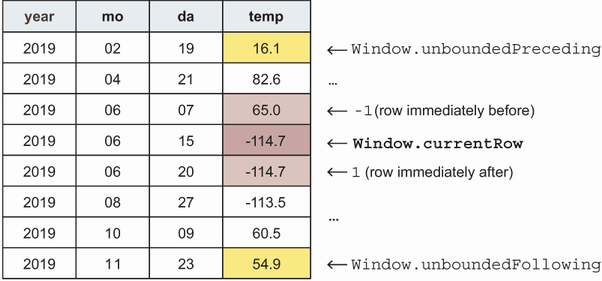

In [32]:
# adding

not_ordered = Window.partitionBy("year").rowsBetween(
    Window.unboundedPreceding, Window.currentRow
)
ordered = not_ordered.orderBy("temp").rangeBetween(
    Window.unboundedPreceding, Window.currentRow
)


gsod_light.withColumn(
    "avg_NO", F.sum("temp").over(not_ordered)
).withColumn("avg_O", F.sum("temp").over(ordered)).where("year = 2018").show()


+------+----+---+---+----+----------+------+-----+
|   stn|year| mo| da|temp|count_temp|avg_NO|avg_O|
+------+----+---+---+----+----------+------+-----+
|996470|2018| 03| 12|55.6|        12| 203.2| 55.6|
|076470|2018| 06| 07|65.0|        24| 147.6|120.6|
|917350|2018| 04| 21|82.6|         9|  82.6|203.2|
+------+----+---+---+----+----------+------+-----+



In [33]:
# note : If your window spec is not ordered using a boundary is a non deterministic
# operation. Spark will not guarantee that your window will contain the same values as
# we are not ordering within a window before picking the boundary. This also Applies if you
# order the dataframe in a previous operations. If you use boundary provide an explicit ordering clause